# Result Analysis

In this notebook, we perform a result analysis of our model in two aspects:

1. whether the model is able to differentiate similar papers published by the same author, while at the same time discovering their shared topics

2. whether the model is able to give precise results compared to manual labeling

To start, we select 5 papers published by Professor Shang:
- CrossWeigh
    - Semantic Scholar: https://www.semanticscholar.org/paper/CrossWeigh%3A-Training-Named-Entity-Tagger-from-Wang-Shang/997855e1f17d34dd3922d953a587742d198844e6
    - PDF: https://www.aclweb.org/anthology/D19-1519.pdf
- AutoPhrase
    - Semantic Scholar: https://www.semanticscholar.org/paper/Automated-Phrase-Mining-from-Massive-Text-Corpora-Shang-Liu/96808500be49f3d502055bab1edd30dcbec4b99b
    - PDF: http://hanj.cs.illinois.edu/pdf/tkde18_jshang2.pdf
- LM-LSTM-CRF
    - Semantic Scholar: https://www.semanticscholar.org/paper/Empower-Sequence-Labeling-with-Task-Aware-Neural-Liu-Shang/7647a06965d868a4f6451bef0818994100a142e8
    - PDF: https://arxiv.org/pdf/1709.04109.pdf
- AutoNER
    - Semantic Scholar: https://www.semanticscholar.org/paper/Learning-Named-Entity-Tagger-using-Domain-Specific-Shang-Liu/5201efab94c9376ef894f6f33cab06a5c5e00073
    - PDF: https://www.aclweb.org/anthology/D18-1230.pdf
- SetExpan
    - Semantic Scholar: https://www.semanticscholar.org/paper/SetExpan%3A-Corpus-Based-Set-Expansion-via-Context-Shen-Wu/741d50647afac926dce001160d8253c7a5c14ca3
    - PDF: https://arxiv.org/pdf/1910.08192.pdf

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns
#ignore future warning because of different versions in the environment
import warnings
warnings.filterwarnings("ignore") 

In [2]:
dirs = os.listdir('../references/result_analysis')
if '.DS_Store' in dirs:
    dirs.remove('.DS_Store')
dirs

['CrossWeigh', 'AutoPhrase', 'LM-LSTM-CRF', 'AutoNER', 'SetExpan']

### 1. Ability to compare and contrast similar papers published by the same author

First we get the AutoPhrase results for all 5 papers. We select high quality phrases (quality score > 0.5) only.

In [3]:
autophrase = {}
autophrase_all = {}
autophrase_stats = pd.DataFrame()
for directory in dirs:
    fp = '../references/result_analysis/' + directory + '/AutoPhrase.txt'
    df = pd.read_csv(fp, delimiter='\t', header=None, names=['score', 'phrase'])
    df = df[['phrase', 'score']]
    autophrase_all[directory] = df
    df = df[df['score'] > 0.5]
    autophrase[directory] = df
    autophrase_stats[directory] = df['score'].describe()
autophrase_df = pd.concat(autophrase, axis=1)
autophrase_df.head(15)

CrossWeigh            \
                                       phrase     score   
0                            maccabi tel aviv  0.953615   
1                            hapoel jerusalem  0.947004   
2                 natural language processing  0.876014   
3                                tel aviv org  0.853902   
4                               lstm cnns crf  0.836071   
5                            natural language  0.792397   
6   association for computational linguistics  0.786124   
7                   computational linguistics  0.773940   
8                            cross validation  0.759089   
9                   entity disjoint filtering  0.748422   
10                        potentially mistake  0.744366   
11                   named entity recognition  0.742255   
12                            entity disjoint  0.726647   
13                                    chicago  0.720033   
14                                pos tagging  0.717565   

                     AutoPhrase                   LM-LSTM-CRF          \
                         phrase     score              phrase   score   
0        information extraction  0.900436     neural networks  0.9455   
1                knowledge base  0.898069         conll03 ner  0.8955   
2               domain specific  0.863229      highway layers  0.8715   
3                  text corpora  0.845831      language model  0.8135   
4          high quality phrases  0.830262         pos tagging  0.8105   
5   quality single word phrases  0.822869             bi lstm  0.8095   
6                 phrase mining  0.798362       highway units  0.7855   
7    wikipedia article datasets  0.790736   sequence labeling  0.7615   
8                          dw ½  0.789586            lstm crf  0.7555   
9                phrase quality  0.787390  conditional random  0.7545   
10          single word phrases  0.779024   transfer learning  0.7525   
11                          auc  0.776646            ner task  0.7485   
12                word sequence  0.770474          state size  0.7365   
13                           cn  0.767391      word embedding  0.7355   
14                raw frequency  0.765840       task specific  0.7345   

                                      AutoNER            \
                                       phrase     score   
0                                  jiawei han  0.883683   
1   association for computational linguistics  0.838017   
2                                     test f1  0.831583   
3                            natural language  0.826750   
4                                   xiang ren  0.797167   
5                             domain specific  0.788800   
6                              modified iobes  0.785000   
7                        ablation experiments  0.761417   
8                                  pre rec f1  0.760083   
9                                    lstm crf  0.707050   
10                               named entity  0.703500   
11                                       data  0.680852   
12                                 dictionary  0.679280   
13                             tagging scheme  0.673500   
14                                  knowledge  0.672533   

                          SetExpan            
                            phrase     score  
0                  bipartite graph  0.861667  
1                       data model  0.810833  
2                 entity intrusion  0.803333  
3                   semantic drift  0.740667  
4                       california  0.731913  
5                       pubmed cvd  0.731000  
6                            texas  0.730487  
7                    grained types  0.719167  
8   io n pte word2vec egoset seisa  0.714667  
9                        skip gram  0.714333  
10                    ranked lists  0.707000  
11                             act  0.706530  
12              candidate entities  0.699167  
13                       free text  0.697500  
14                    expanded se

As we can see from the dataframe above, there are some phrases, such as "maccabi tel aviv," "jiawei han," and "california," that ended up at the top of the ranked list while they are actually not domain-specific. 

To filter out these nonsignificant phrases, our model applies weight to the AutoPhrase result using the pre-processed arXiv dataset. For pre-processing, we have split the arXiv dataset into domains and run AutoPhrase on each of them to get domain specific phrases. For the 5 papers we are using, we select the domain to be "computer science" and the weighted results with high quality phrases (quality score > 0.5) are as follows:

In [4]:
weighted = {}
weighted_all = {}
weighted_stats = pd.DataFrame()
for directory in dirs:
    fp = '../references/result_analysis/' + directory + '/weighted_AutoPhrase.csv'
    df = pd.read_csv(fp, index_col='Unnamed: 0')
    weighted_all[directory] = df
    df = df[df['score'] > 0.5]
    weighted[directory] = df
    weighted_stats[directory] = df['score'].describe()
weighted_df = pd.concat(weighted, axis=1)
weighted_df.head(15)

CrossWeigh                        AutoPhrase            \
                         phrase     score                  phrase     score   
0   natural language processing  0.838990          knowledge base  0.873407   
1              natural language  0.757931  information extraction  0.856859   
2     computational linguistics  0.740970         domain specific  0.811338   
3              cross validation  0.718658            text corpora  0.770488   
4      named entity recognition  0.705910    keyphrase extraction  0.719894   
5                   pos tagging  0.696215              pos tagger  0.712723   
6                      lstm crf  0.606123        natural language  0.690965   
7                       chicago  0.593747    massive text corpora  0.650525   
8                         japan  0.571026                      cn  0.630996   
9                            f1  0.537041                     auc  0.630004   
10                        china  0.530006                 pos tag  0.625162   
11                           nz  0.524289                    ieee  0.618373   
12                          loc  0.509845               wikipedia  0.609086   
13                           mi  0.500274                illinois  0.604065   
14                          NaN       NaN          domain experts  0.594662   

                 LM-LSTM-CRF                         AutoNER            \
                      phrase     score                phrase     score   
0            neural networks  0.854883      natural language  0.790789   
1                pos tagging  0.786385       domain specific  0.741383   
2                    bi lstm  0.732485          named entity  0.673549   
3          sequence labeling  0.732107   distant supervision  0.627576   
4             word embedding  0.714797              lstm crf  0.597881   
5          transfer learning  0.703784  ablation experiments  0.580176   
6             language model  0.698183  distantly supervised  0.561613   
7            word embeddings  0.667826                  ncbi  0.536222   
8                   lstm crf  0.638850                   ner  0.516699   
9         conditional random  0.630958                   ram  0.516429   
10                  f1 score  0.625515                    f1  0.507561   
11  named entity recognition  0.608186                   liu  0.505426   
12             task specific  0.601384                   NaN       NaN   
13            highway layers  0.594081                   NaN       NaN   
14           language models  0.593771                   NaN       NaN   

           SetExpan            
             phrase     score  
0   bipartite graph  0.829287  
1         skip gram  0.664785  
2      ranked lists  0.644381  
3    semantic drift  0.628639  
4      text corpora  0.609257  
5             texas  0.608994  
6    coarse grained  0.607136  
7        california  0.601513  
8        skip grams  0.600160  
9       ranked list  0.590317  
10              act  0.574041  
11        free text  0.563177  
12              apr  0.563165  
13              usa  0.561447  
14           pubmed  0.557891

As we can see from the dataframe above, there are some phrases, such as "natural language," "pos tagging," "lstm crf," and "text corpora," shared across these 5 papers. At the same time, each of these papers has its own unique phrases, such as "cross validation" for CrossWeigh, "knowledge base" for AutoPhrase, "sequence labeling" for LM-LSTM-CRF, "distant supervision" for AutoNER, and "bipartite graph" for SetExpan. 

Thus our model is able to differentiate similar papers published by the same author, while at the same time discovering their shared topics.

The density plots of quality scores before and after applying weight are as follows:

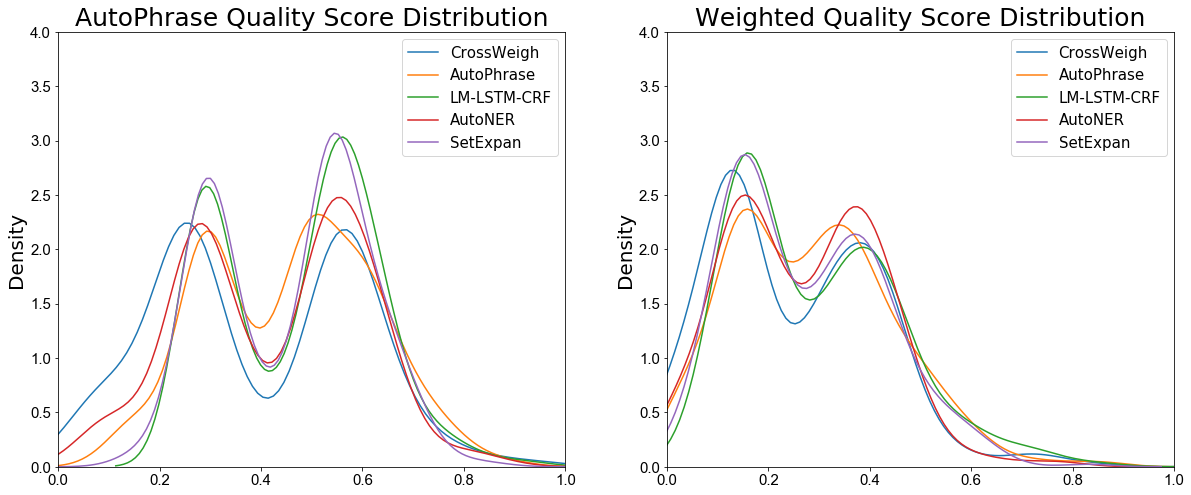

In [5]:
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
for directory in autophrase_all:
    sns.distplot(autophrase_all[directory]['score'].to_list(), hist=False, label=directory)
plt.title('AutoPhrase Quality Score Distribution', fontsize=25)
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.ylabel('Density', fontsize=20)
plt.legend(loc="best", fontsize=15)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(15)

ax = plt.subplot(1, 2, 2)
for directory in weighted_all:
    sns.distplot(weighted_all[directory]['score'].to_list(), hist=False, label=directory)
plt.title('Weighted Quality Score Distribution', fontsize=25)
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.ylabel('Density', fontsize=20)
plt.legend(loc="best", fontsize=15)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(15)

# plt.savefig('../data/report/Quality Score Distribution.png')
plt.show()

The quality score distribution shifts to the left after applying the weight. This is expected because nonsignificant phrases are weighted down.

### 2. Ability to give precise results comparing to manual labeling

To do this, we annotate the weighted results by manual checking and labeling whether the phrases can actually represent the paper. We compare the accuracy for phrases with a quality score > 0.5, > 0.6, and > 0.7. 

In [6]:
annote_stats = pd.DataFrame(columns=['Article', 
                                     'Accuracy (quality score > 0.5)', 
                                     'Accuracy (quality score > 0.6)', 
                                     'Accuracy (quality score > 0.7)'])
for directory in dirs:
    fp = '../references/result_analysis/' + directory + '/annotation.csv'
    df = pd.read_csv(fp, index_col='Unnamed: 0')
    df2 = df[df['score'] > 0.6]
    df3 = df[df['score'] > 0.7]
    annote_stats = annote_stats.append({'Article': directory, 
                                        'Accuracy (quality score > 0.5)': df['label'].mean(), 
                                        'Accuracy (quality score > 0.6)': df2['label'].mean(),
                                        'Accuracy (quality score > 0.7)': df3['label'].mean()}, ignore_index=True)
annote_stats

,Article,Accuracy (quality score > 0.5),Accuracy (quality score > 0.6),Accuracy (quality score > 0.7)
0,CrossWeigh,0.642857,1.000000,1.0
1,AutoPhrase,0.780000,0.857143,1.0
2,LM-LSTM-CRF,0.888889,0.923077,1.0
3,AutoNER,0.833333,1.000000,1.0
4,SetExpan,0.629630,0.888889,1.0


As we can see from the dataframe above, accuracy is higher for phrases with a higher quality score. 

Thus our model is able to give precise results compared to manual labeling.

The precision-recall curves are plotted as follows:

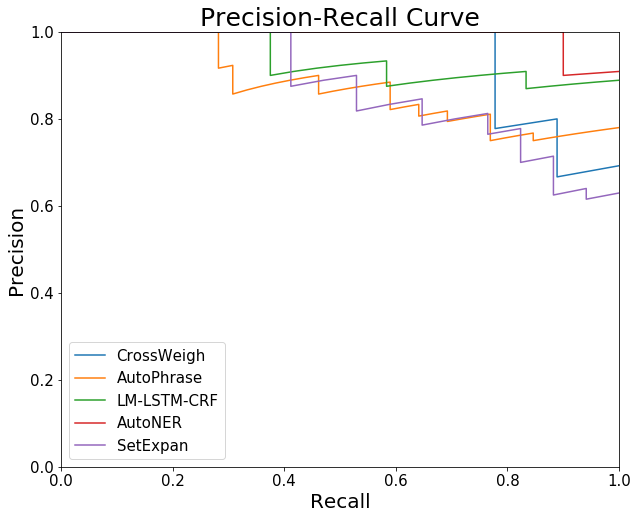

In [7]:
plt.figure(figsize=(10, 8))
for directory in dirs:
    fp = '../references/result_analysis/' + directory + '/annotation.csv'
    sample = pd.read_csv(fp, index_col='Unnamed: 0')
    precision, recall, thresholds = precision_recall_curve(
        y_true=sample['label'],
        probas_pred=sample['score'])
    plt.plot(recall, precision, scalex=False, scaley=False, label=directory)
plt.title('Precision-Recall Curve', fontsize=25)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.legend(loc="best", fontsize=15)
plt.tick_params(axis='both',labelsize=15)

# plt.savefig('../data/report/Precision-Recall Curve.png')
plt.show()